### Install Dependencies

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/My Drive/train.csv'
df = pd.read_csv(file_path)
df.shape

(159571, 8)

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df["comment_text"]
Y = df[df.columns[2:]]

In [ ]:
Y

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
159566,0,0,0,0,0,0
159567,0,0,0,0,0,0
159568,0,0,0,0,0,0
159569,0,0,0,0,0,0


In [ ]:
MAX_FEATURES = 20000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(
    max_tokens = MAX_FEATURES,
    output_sequence_length = 1800,
    output_mode = 'int'
)

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[ 645,   76,    2, ...,    0,    0,    0],
       [   1,   54, 2489, ...,    0,    0,    0],
       [ 425,  441,   70, ...,    0,    0,    0],
       ...,
       [   1, 7392,  383, ...,    0,    0,    0],
       [   5,   12,  534, ...,    0,    0,    0],
       [   5,    8,  130, ...,    0,    0,    0]])>

In [ ]:
#MCSHBAP - map,chache,shuffle,batch,prefetch from_tensor_slices,list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,Y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

### Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Bidirectional,Dense,Embedding

In [ ]:
model = Sequential()
# Create the embedding Layer
model.add(Embedding(MAX_FEATURES+1,32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32,activation = 'tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128,activation = 'relu'))
model.add(Dense(256,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
## Final layer
model.add(Dense(6,activation = 'sigmoid'))

In [ ]:
model.compile(loss = 'BinaryCrossentropy',optimizer = 'Adam')

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 754s 107ms/step - loss: 0.0839 - val_loss: 0.0497
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 795s 106ms/step - loss: 0.0481 - val_loss: 0.0421
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 741s 106ms/step - loss: 0.0445 - val_loss: 0.0389
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 748s 107ms/step - loss: 0.0406 - val_loss: 0.0377
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 809s 108ms/step - loss: 0.0378 - val_loss: 0.0333
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 782s 105ms/step - loss: 0.0341 - val_loss: 0.0315
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 728s 104ms/step - loss: 0.0328 - val_loss: 0.0308
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 719s 103ms/step - loss: 0.0301 - val_loss: 0.0273
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 710s 102ms/step - loss: 0.0290 - val_loss: 0.0255
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 761s 104ms/step - loss: 0.0270 - val_loss: 0.0239


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1800, 32)            │         640,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,195,060 (8.37 MB)

 Trainable params: 731,686 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,463,374 (5.58 MB)

<Figure size 800x500 with 0 Axes>

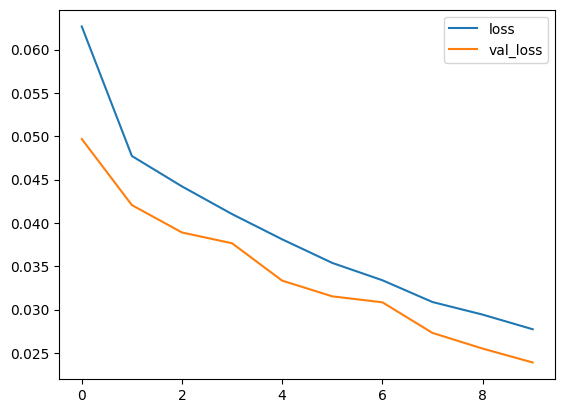

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

### Make Predictions

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hit you.')

In [ ]:
# Reshape input_text to add a batch dimension
input_text = tf.reshape(input_text, (1, -1))  # Shape becomes (1, 1800)

# Make prediction
res = model.predict(input_text)
print(res)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
[[0.99880826 0.16455092 0.98882955 0.01096526 0.9646064  0.07719342]]


In [ ]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [ ]:
Y.columns

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0]])

In [ ]:
res.shape

(1, 6)

### Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')


Precision: 0.8853389024734497, Recall:0.8589223623275757, Accuracy:0.5105316042900085


###  Test and Gradio

In [ ]:
!pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import tensorflow as tf
import gradio as gr

In [ ]:
model.save('toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('toxicity.h5')

In [42]:
input_str = vectorizer('hey i am freaking hate you!')

In [43]:
s = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [44]:
res

array([[0.99880826, 0.16455092, 0.98882955, 0.01096526, 0.9646064 ,
        0.07719342]], dtype=float32)

In [45]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [46]:
interface = gr.Interface(
    fn=score_comment,
    inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
    outputs="text"
)

In [47]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://02eb8c42bca945a65b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
